# Room Occupancy Estimation Data Set
link: https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation# (changed)

new link: https://www.kaggle.com/datasets/ananthr1/room-occupancy-estimation-data-set?resource=download


In [42]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# we want our plots to appear inside the notebook
%matplotlib inline 
# import dateformatter
from matplotlib.dates import DateFormatter
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import statsmodels.api as sm

# Importing Data

note: the downsload link request a registered user. In order to be easy, download the csv file into your computer and leave it in the same page of this code. 

# url_download = 'https://www.kaggle.com/datasets/ananthr1/room-occupancy-estimation-data-set/download?datasetVersionNumber=1'

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# old way to use the data
# url_download = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv'
# data = pd.read_csv(url_download)

data = pd.read_csv('drive/MyDrive/pos_IA/Occupancy_Estimation.csv')

# Exploring Data

In [45]:
data.shape

(10129, 19)

In [46]:
estilos = [
    {'selector': 'table',
     'props': [('border', '1px solid black')]}
]
data.head().style.set_table_styles(estilos)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.940000,24.750000,24.560000,25.380000,121,34,53,40,0.080000,0.190000,0.060000,0.060000,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.940000,24.750000,24.560000,25.440000,121,33,53,40,0.930000,0.050000,0.060000,0.060000,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.000000,24.750000,24.500000,25.440000,121,34,53,40,0.430000,0.110000,0.080000,0.060000,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.000000,24.750000,24.560000,25.440000,121,34,53,40,0.410000,0.100000,0.100000,0.090000,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.000000,24.750000,24.560000,25.440000,121,34,54,40,0.180000,0.060000,0.060000,0.060000,390,0.253846,0,0,1


## Attribute Information:

* Date: YYYY/MM/DD 
* Time: HH:MM:SS
* Temperature: In degree Celsius
* Light: In Lux
* Sound: In Volts (amplifier output read by ADC)
* CO2: In PPM
* CO2 Slope: Slope of CO2 values taken in a sliding window
* PIR: Binary value conveying motion detection
* Room_Occupancy_Count: Ground Truth

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [48]:
# are there any missing values?
data.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [49]:
data.describe().style.set_table_styles(estilos)

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.016290,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.304170,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.000000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.000000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.000000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.000000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.000000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


<ipython-input-50-3db7537ae8ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


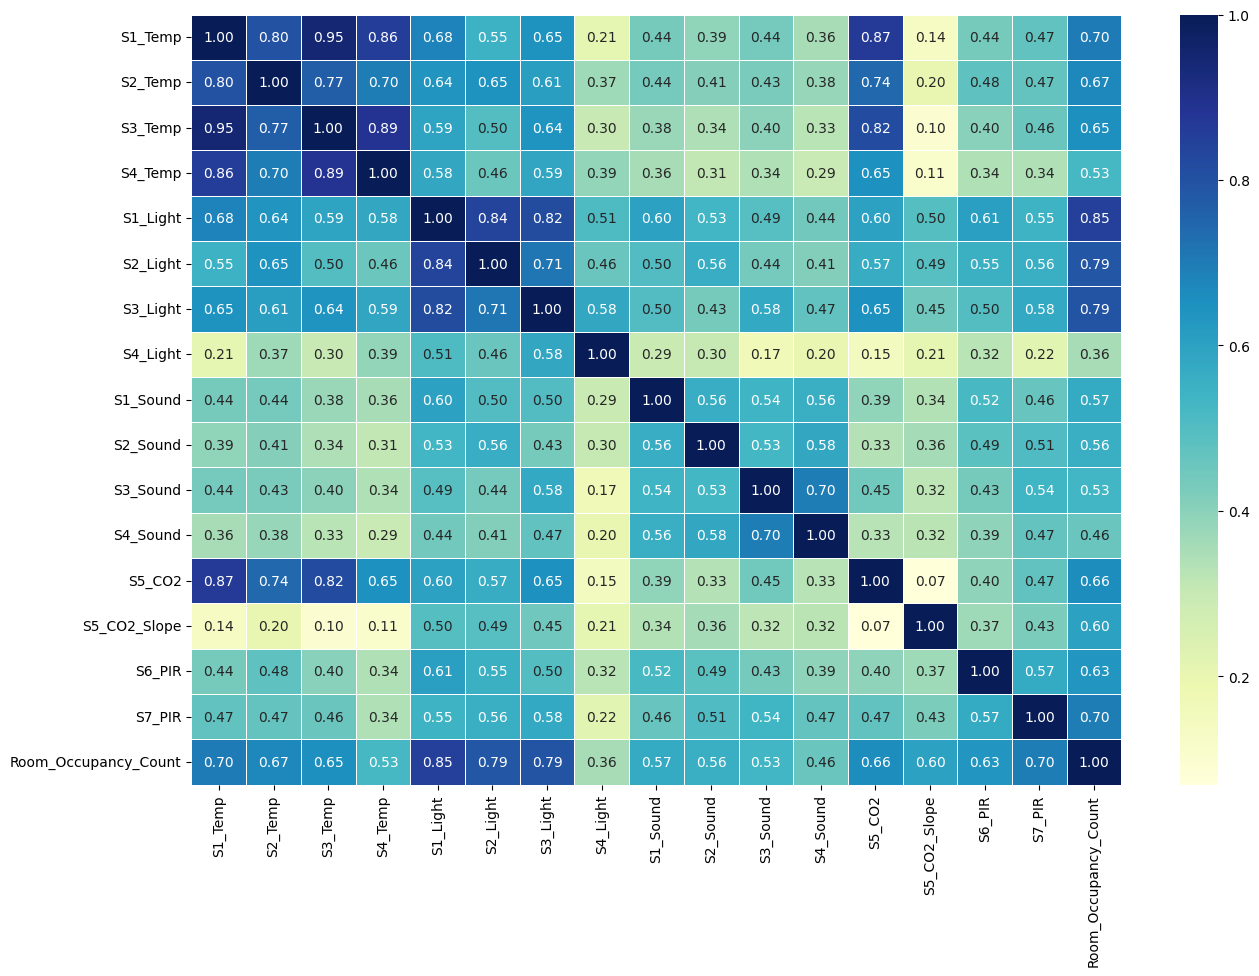

In [50]:
# making correlation pretter
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim()
fig.savefig('corr.png')

In [51]:
# join columns Date and time to work with time series
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_timedelta(data['Time'])
data['DateTime'] = data['Date'] + data['Time']
data.set_index("DateTime", inplace = True)
data = data.drop(columns=['Date', 'Time'])
data.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
DateTime,,,,,,,,,,,,,,,,,
2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [52]:
data.shape

(10129, 17)

# Mean of the attributes

In [53]:
media = pd.DataFrame()
media['temp'] = (data['S1_Temp'] + data['S2_Temp'] + data['S3_Temp'] + data['S4_Temp'])/4
media['light'] = (data['S1_Light'] + data['S2_Light'] + data['S3_Light'] + data['S4_Light'])/4
media['sound'] = (data['S1_Sound'] + data['S2_Sound'] + data['S3_Sound'] + data['S4_Sound'])/4
media['pir'] = (data['S6_PIR'] + data['S7_PIR'])/2
media.head()

,temp,light,sound,pir
DateTime,,,,
2017-12-22 10:49:41,24.9075,62.00,0.0975,0.0
2017-12-22 10:50:12,24.9225,61.75,0.2750,0.0
2017-12-22 10:50:42,24.9225,62.00,0.1700,0.0
2017-12-22 10:51:13,24.9375,62.00,0.1750,0.0
2017-12-22 10:51:44,24.9375,62.25,0.0900,0.0


In [54]:
temp_data = data.loc['2018-01-10']
temp_media = media.loc['2018-01-10']

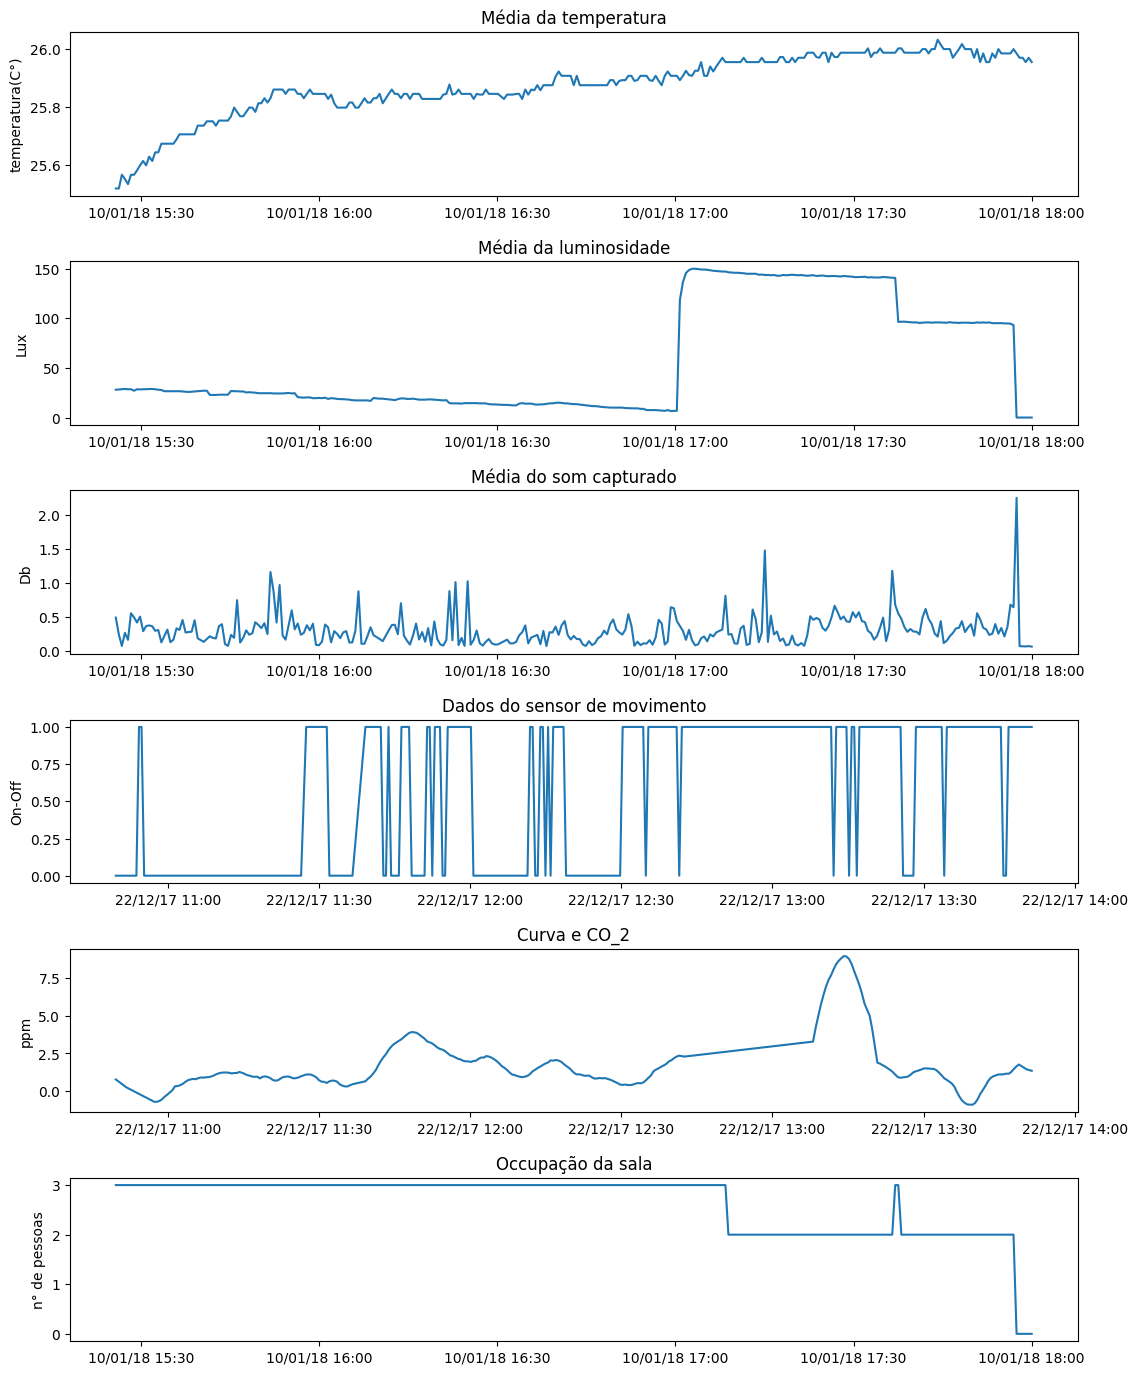

In [55]:
interval = 300
fig, ax = plt.subplots(6, 1, figsize=(13, 17))
fig.subplots_adjust(hspace=0.4)

ax[0].plot(temp_media['temp'].iloc[:interval]) 
ax[0].title.set_text('Média da temperatura')
ax[0].set_ylabel('temperatura(C°)')
ax[0].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax[1].plot(temp_media['light'].iloc[:interval]) 
ax[1].title.set_text('Média da luminosidade')
ax[1].set_ylabel('Lux')
ax[1].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax[2].plot(temp_media['sound'].iloc[:interval]) 
ax[2].title.set_text('Média do som capturado')
ax[2].set_ylabel('Db')
ax[2].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax[3].plot(data['S7_PIR'].iloc[:interval]) 
ax[3].title.set_text('Dados do sensor de movimento')
ax[3].set_ylabel('On-Off')
ax[3].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax[4].plot(data['S5_CO2_Slope'].iloc[:interval])
ax[4].title.set_text('Curva e CO_2')
ax[4].set_ylabel('ppm')
ax[4].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax[5].plot(temp_data['Room_Occupancy_Count'].iloc[:interval]) 
ax[5].title.set_text('Occupação da sala')
ax[5].set_ylabel('n° de pessoas')
ax[5].xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))


# fig.suptitle('Análise temperatura ')
plt.show()
fig.savefig('medias.png')

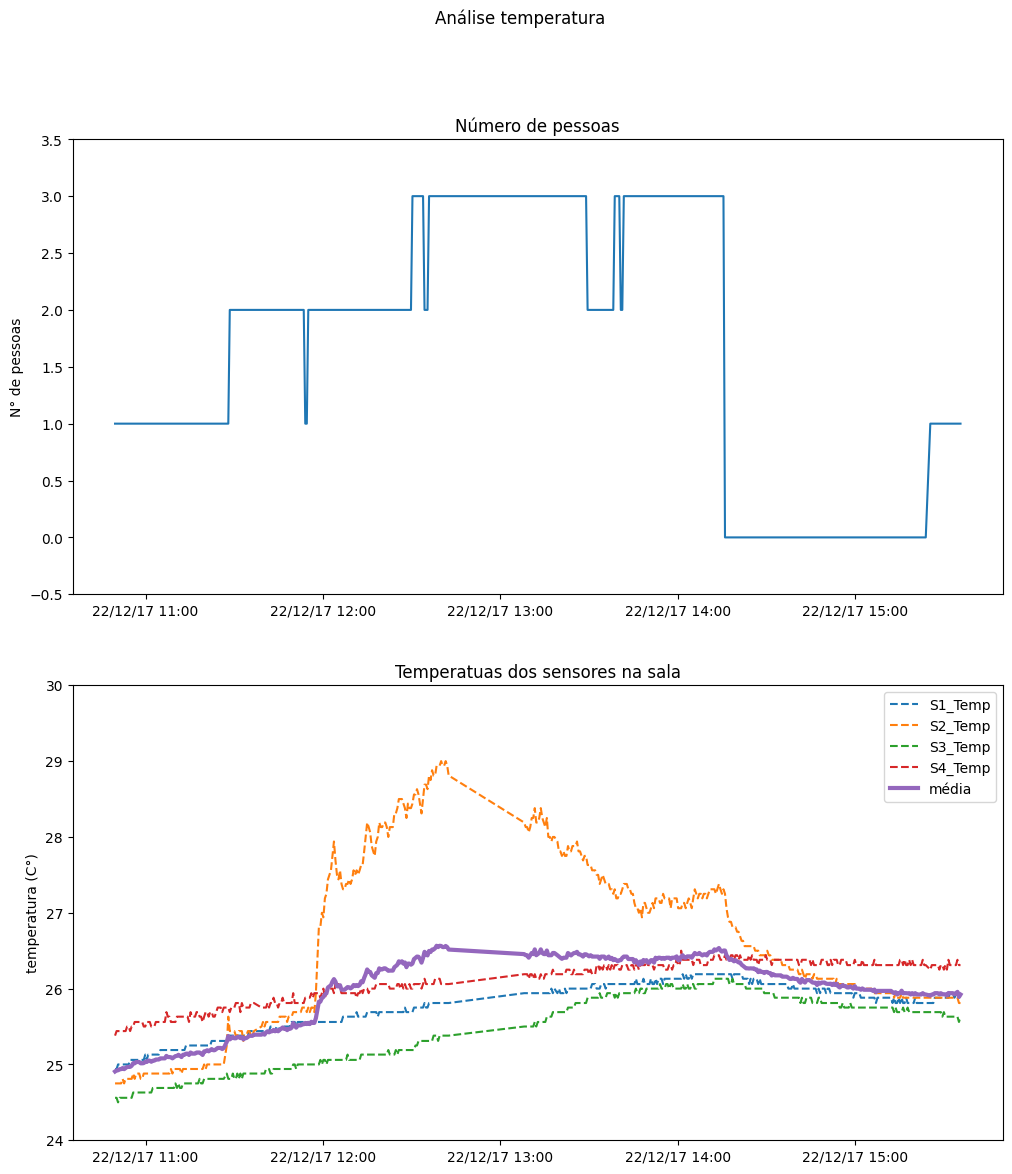

In [56]:
interval = 500

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 13))
fig.subplots_adjust(hspace=0.2)

ax1.plot(data['Room_Occupancy_Count'].iloc[:interval])
ax1.title.set_text('Número de pessoas')
ax1.set_ylabel('N° de pessoas')
ax1.set_ylim(-0.5,3.5)
ax1.xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))

ax2.plot(data['S1_Temp'].iloc[:interval], label='S1_Temp', linestyle='dashed')
ax2.plot(data['S2_Temp'].iloc[:interval], label='S2_Temp', linestyle='dashed')
ax2.plot(data['S3_Temp'].iloc[:interval], label='S3_Temp', linestyle='dashed')
ax2.plot(data['S4_Temp'].iloc[:interval], label='S4_Temp', linestyle='dashed')
ax2.plot(media['temp'].iloc[:interval], label='média', linewidth=3)

ax2.set_ylim(24,30)
ax2.title.set_text('Temperatuas dos sensores na sala')
ax2.set_ylabel('temperatura (C°)')
ax2.xaxis.set_major_formatter(DateFormatter("%d/%m/%y %H:%M"))
ax2.legend()

fig.suptitle('Análise temperatura ')
plt.show()
fig.savefig('temperaturas.png')

# Regression analysis

In [57]:
# Define the independent variables (X) and the dependent variable (y)
X = data[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
y = data['Room_Occupancy_Count']

In [58]:
# Add a constant to the X values to estimate the intercept
X = sm.add_constant(X)

In [59]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

In [60]:
# Print a summary of the regression results
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.894
Model:                              OLS   Adj. R-squared:                  0.894
Method:                   Least Squares   F-statistic:                     5318.
Date:                  Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                          18:18:56   Log-Likelihood:                -1877.0
No. Observations:                 10129   AIC:                             3788.
Df Residuals:                     10112   BIC:                             3911.
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.0051     

# Modeling

In [61]:
# split data into X and y
X = data.drop('Room_Occupancy_Count', axis=1)
y = data['Room_Occupancy_Count']

In [62]:
# Split data into training validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('As dimensões dos dados X_train são: ' + str(X_train.shape))
print('As dimensões dos dados y_train são: ' + str(len(y_train)))
print('As dimensões dos dados X_val são: ' + str(X_val.shape))
print('As dimensões dos dados y_val são: ' + str(len(y_val)))
print('As dimensões dos dados X_test são: ' + str(X_test.shape))
print('As dimensões dos dados y_test são: ' + str(len(y_test)))


As dimensões dos dados X_train são: (7090, 16)
As dimensões dos dados y_train são: 7090
As dimensões dos dados X_val são: (1519, 16)
As dimensões dos dados y_val são: 1519
As dimensões dos dados X_test são: (1520, 16)
As dimensões dos dados y_test são: 1520


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# model dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

In [64]:
# Create a function to fit and score models
def evaluate_models_by_score(models, X_train, y_train, X_test, y_test):
    results_by_score = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)

        # Evaluate the model and append its score to model_scores
        results_by_score[name] = model.score(X_test, y_test)
    return results_by_score

In [65]:
results_by_score = evaluate_models_by_score(models, X_train, y_train, X_test, y_test)
results_by_score

{'Linear Regression': 0.8961228553983985,
 'Decision Tree': 0.9668191360729553,
 'Random Forest Regressor': 0.9716621664143849,
 'Gradient Boosting': 0.9748300175610606}

In [66]:
# Finding the best model based on least mean square error (MSE)
best_model = max(results_by_score, key=results_by_score.get)
best_mse = results_by_score[best_model]

In [67]:
print("Resultados da Avaliação:")
for name, mse in results_by_score.items():
    print(f"{name}: MSE = {mse}")

print(f"\nMelhor modelo: {best_model} (MSE = {best_mse})")

Resultados da Avaliação:
Linear Regression: MSE = 0.8961228553983985
Decision Tree: MSE = 0.9668191360729553
Random Forest Regressor: MSE = 0.9716621664143849
Gradient Boosting: MSE = 0.9748300175610606

Melhor modelo: Gradient Boosting (MSE = 0.9748300175610606)


In [68]:
# Create a function to fit and score models
def evaluate_models_by_mse(models, X_train, y_train, X_test, y_test):
    results_mse = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results_mse[name] = mse

    return results_mse

In [69]:
# Evaluate models using training and test data
results_mse = evaluate_models_by_mse(models, X_train, y_train, X_test, y_test)
results_mse

{'Linear Regression': 0.08444473601819014,
 'Decision Tree': 0.028289473684210528,
 'Random Forest Regressor': 0.02249434210526316,
 'Gradient Boosting': 0.020441786973202827}

In [70]:
# Finding the best model based on least mean square error (MSE)
best_model = min(results_mse, key=results_mse.get)
best_mse = results_mse[best_model]

In [71]:
print("Resultados da Avaliação:")
for name, mse in results_mse.items():
    print(f"{name}: MSE = {mse}")

print(f"\nMelhor modelo: {best_model} (MSE = {best_mse})")

Resultados da Avaliação:
Linear Regression: MSE = 0.08444473601819014
Decision Tree: MSE = 0.028289473684210528
Random Forest Regressor: MSE = 0.02249434210526316
Gradient Boosting: MSE = 0.020441786973202827

Melhor modelo: Gradient Boosting (MSE = 0.020441786973202827)


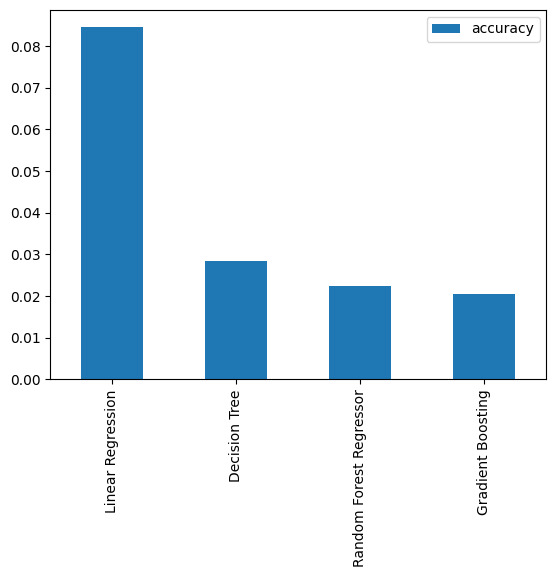

In [72]:
model_compare = pd.DataFrame(results_mse, index=["accuracy"])
model_compare.T.plot.bar();

# Gradient Boosting

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Step 1: Split data into training set and test set
# X_train, X_test, y_train, y_test = ...

# Step 2: Instantiate the Gradient Boosting model
model = GradientBoostingRegressor()

# Step 3: train the model
model.fit(X_train, y_train)

# Step 4: Evaluate model performance
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train R^2: 0.9928926209203146
Test R^2: 0.9746194709065792
Train MSE: 0.005706879944140896
Test MSE: 0.02063256636015458
Train MAE: 0.024392934615469854
Test MAE: 0.03395955749518373


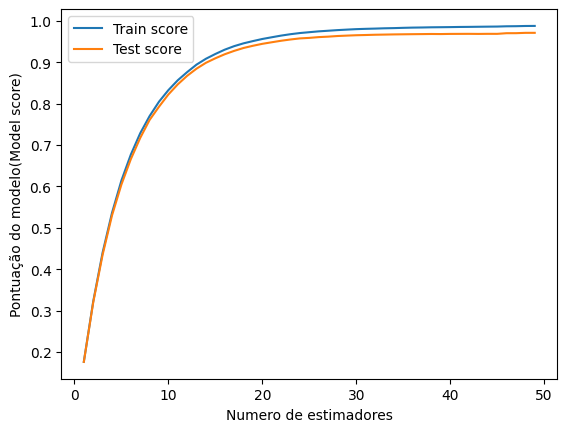

Best number of estimators: 49
Maximum score on the test data: 97.09%


In [74]:
train_scores = []
test_scores = []

# Create a list of different values for n_estimators
n_estimators = range(1, 50)

# Setup Gradient Boosting instance
gbr = GradientBoostingRegressor()

# Loop through different n_estimators
for i in n_estimators:
    gbr.set_params(n_estimators=i)
    
    # Fit the algorithm
    gbr.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(gbr.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(gbr.score(X_test, y_test))

# Plot the scores
plt.plot(n_estimators, train_scores, label="Train score")
plt.plot(n_estimators, test_scores, label="Test score")
plt.xlabel("Numero de estimadores")
plt.ylabel("Pontuação do modelo(Model score)")
plt.legend()
plt.show()

best_ne = n_estimators[np.argmax(test_scores)]
print(f"Best number of estimators: {best_ne}")
print(f"Maximum score on the test data: {max(test_scores)*100:.2f}%")

# Linear Regression

Maximum Linear Regression score on the test data: 89.61%


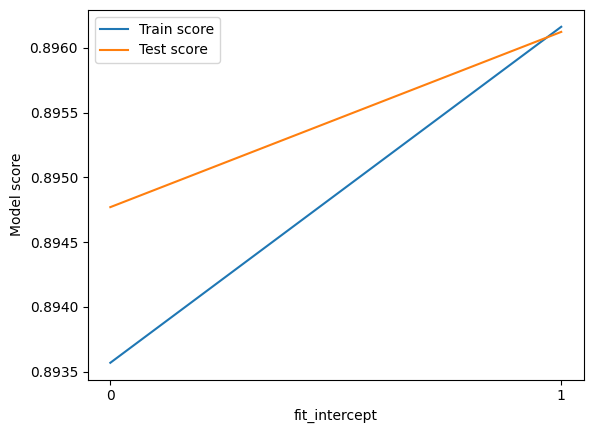

In [77]:
train_scores = []
test_scores = []

# Create a list of different values for the parameter to tune (e.g., number of features, regularization parameter)
# In this case, we will use a list of different values for the fit_intercept parameter
fit_intercepts = [True, False]

# Setup Linear Regression instance
lr = LinearRegression()

# Loop through different fit_intercept values
for fit_intercept in fit_intercepts:
    lr.set_params(fit_intercept=fit_intercept)
    
    # Fit the algorithm
    lr.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(lr.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(lr.score(X_test, y_test))

plt.plot(fit_intercepts, train_scores, label="Train score")
plt.plot(fit_intercepts, test_scores, label="Test score")
plt.xticks([True, False])
plt.xlabel("fit_intercept")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum Linear Regression score on the test data: {max(test_scores)*100:.2f}%")

# DecisionTreeRegressor

Maximum Decision Tree Regressor score on the test data: 96.76%


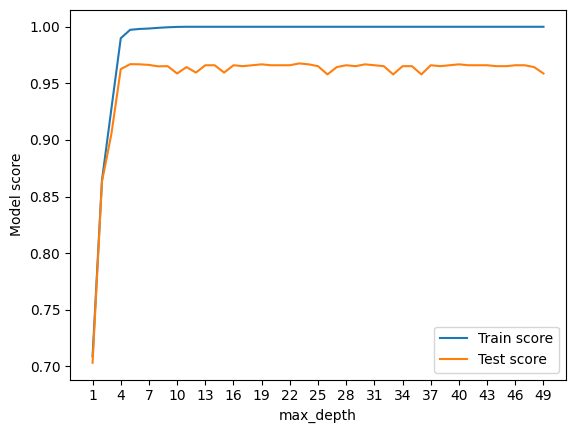

In [80]:
# Let's tune Decision Tree Regressor

train_scores = []
test_scores = []

# Create a list of different values for the max_depth parameter
max_depths = range(1, 50)

# Setup Decision Tree Regressor instance
dt = DecisionTreeRegressor()

# Loop through different max_depth values
for max_depth in max_depths:
    dt.set_params(max_depth=max_depth)
    
    # Fit the algorithm
    dt.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(dt.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(dt.score(X_test, y_test))

plt.plot(max_depths, train_scores, label="Train score")
plt.plot(max_depths, test_scores, label="Test score")
plt.xticks(np.arange(1, 50, 3))
plt.xlabel("max_depth")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum Decision Tree Regressor score on the test data: {max(test_scores)*100:.2f}%")

# RandomForestRegressor

Maximum RandomForestRegressor score on the test data: 97.52%


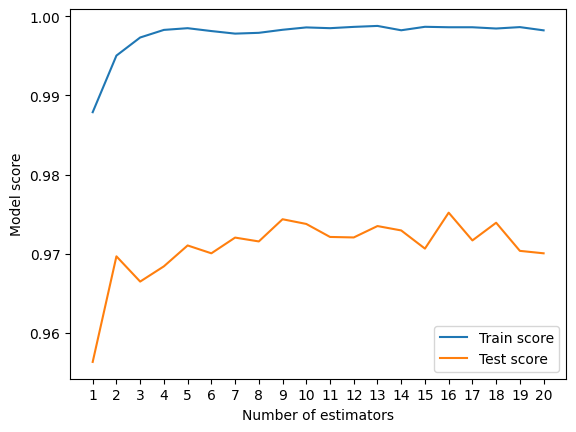

In [83]:
# Let's tune RandomForestRegressor

train_scores = []
test_scores = []

# Create a list of different values for the number of estimators
n_estimators = range(1, 21)

# Setup RandomForestRegressor instance
rf = RandomForestRegressor()

# Loop through different n_estimators values
for n_estimator in n_estimators:
    rf.set_params(n_estimators=n_estimator)
    
    # Fit the algorithm
    rf.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(rf.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(rf.score(X_test, y_test))

plt.plot(n_estimators, train_scores, label="Train score")
plt.plot(n_estimators, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of estimators")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum RandomForestRegressor score on the test data: {max(test_scores)*100:.2f}%")

# Otimização do modelo - GradientBoostingRegressor

In [86]:
# Define the hyperparameters to be tested
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

# Create an instance of the Gradient Boosting model
gb = GradientBoostingRegressor()

# Create the object GridSearchCV
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best found hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_gb = GradientBoostingRegressor(**best_params)
best_gb.fit(X_train, y_train)

# Evaluate the optimized model on test data
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R²:", r2)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Test MSE: 0.023756423102544347
Test MAE: 0.013086462525139427
Test R²: 0.9707767527710874


# Final test

In [87]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit scaler to training data
scaler.fit(X_train)

# Pre-process test data
X_test_final = scaler.transform(X_test)  # Apply the same normalization used on the training data

# Apply the Gradient Boosting model to test data
y_pred_final = model.predict(X_test)  # Model is the optimized Gradient Boosting model

# Calculate evaluation metrics
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("Test MSE:", mse_final)
print("Test MAE:", mae_final)
print("Test R²:", r2_final)

Test MSE: 0.02063256636015458
Test MAE: 0.03395955749518373
Test R²: 0.9746194709065792
